cd OneDrive/Bureaublad/ARC/deep-multimodal-learning/mvae/Scripts/activate.bat

In [1]:
import torch
from functions import get_loader, plot_loss_histories
from functions_cae import train_cae, validate_cae, deepCAE, SimpleCAE, SimpleCAE_Dropout, visualize_latent_space, visualize_reconstruction, get_latent_dataset
import torch.nn as nn
from functions_mlp import rawMLP, train_mlp, validate_mlp, caeMLP
import matplotlib.pyplot as plt

In [2]:
##### CONFIG
NUM_EPOCHS = 1
LR_RATE = 1e-3
BATCH_SIZE = 16
WEIGHT_DECAY = 1e-5

DEVICE = ""
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA is available. Using GPU...")
else:
    DEVICE = torch.device("cpu")
    print("CUDA is not available. Using CPU...")

BASE_PATH = 'C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/data_v2'

# Define the tool names and actions
TOOL_NAMES = ['hook', 'ruler', 'spatula', 'sshot']
ACTIONS = ['left_to_right', 'pull', 'push', 'right_to_left']

# All available object names
train_objects = ['0_woodenCube', '1_pearToy', '2_yogurtYellowbottle', '3_cowToy', '4_tennisBallYellowGreen',
            '5_blackCoinbag', '6_lemonSodaCan', '7_peperoneGreenToy', '8_boxEgg','9_pumpkinToy',
            '10_tomatoCan', '11_boxMilk']

val_objects = ['12_containerNuts', '13_cornCob', '14_yellowFruitToy',
            '15_bottleNailPolisher']

test_objects =['16_boxRealSense', '17_clampOrange', '18_greenRectangleToy', '19_ketchupToy']

CUDA is available. Using GPU...


In [3]:
# cae_lossfunction = nn.MSELoss()
cae_lossfunction = nn.BCELoss()

train_loader = get_loader(BASE_PATH, train_objects, TOOL_NAMES, ACTIONS, "color", "training", batch_size=BATCH_SIZE)
val_loader = get_loader(BASE_PATH, val_objects, TOOL_NAMES, ACTIONS, "color", "validation", batch_size=BATCH_SIZE)
test_loader = get_loader(BASE_PATH, test_objects, TOOL_NAMES, ACTIONS, "color", "testing", batch_size=BATCH_SIZE)

# Training loop
cae = SimpleCAE().to(DEVICE)
#cae = deepCAE().to(DEVICE)
#cae = SimpleCAE_Dropout().to(DEVICE)
cae_optimizer_adam = torch.optim.Adam(cae.parameters(), lr=LR_RATE)
cae_optimizer_sgd = torch.optim.SGD(cae.parameters(), lr=LR_RATE, momentum=0.9)
cae_optimizer_adamw = torch.optim.AdamW(cae.parameters(), lr=LR_RATE, weight_decay=1e-2)

trained_cae, cae_batch_loss_history, cae_epoch_loss_history = train_cae(cae, val_loader, cae_lossfunction, cae_optimizer_sgd, NUM_EPOCHS, DEVICE)
avg_val_loss, cae_validation_loss_history = validate_cae(trained_cae, test_loader, cae_lossfunction, DEVICE)

Epoch [1/1], Loss: 0.6985
Average Validation Loss: 0.6986920297145843


In [4]:
# Config MLP
mlp_lossfunction = nn.CrossEntropyLoss()  # Loss function
output_dim = 4 

# Extract features from the train and validation sets
train_dataset = get_latent_dataset(trained_cae, train_loader)
val_dataset = get_latent_dataset(trained_cae, val_loader)

# Create DataLoaders for the extracted features
mlp_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
mlp_val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize
input_dim = train_dataset[:][0].size(1)
mlp = caeMLP(input_dim, output_dim).to(DEVICE)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=LR_RATE)

# Train the model
trained_mlp, mlp_epoch_avg_losses, mlp_epoch_accuracys = train_mlp(mlp, mlp_lossfunction, mlp_optimizer, mlp_train_loader, NUM_EPOCHS, DEVICE)

# Validate the model
validate_mlp(mlp, mlp_lossfunction, mlp_val_loader, DEVICE)

Epoch [1/1], Train Loss: 1.6464, Train Acc: 0.26
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3], device='cuda:0')
tensor([3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3], device='cuda:0')
tensor([3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3], device='cuda:0')
tensor([3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0], device

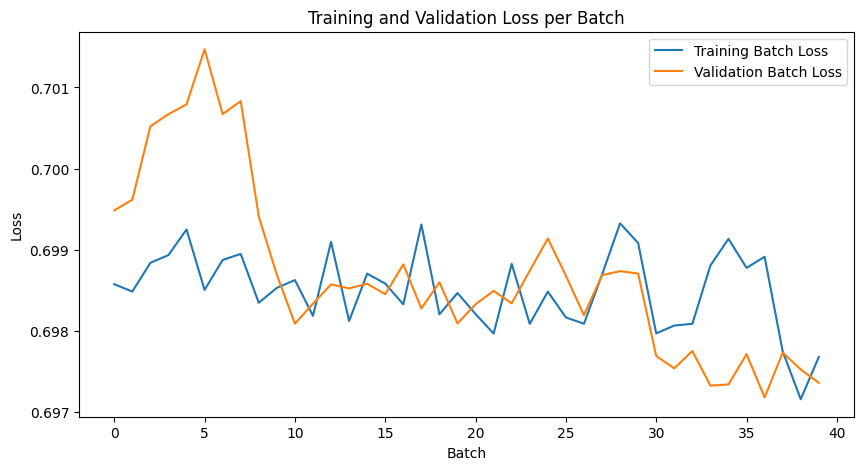

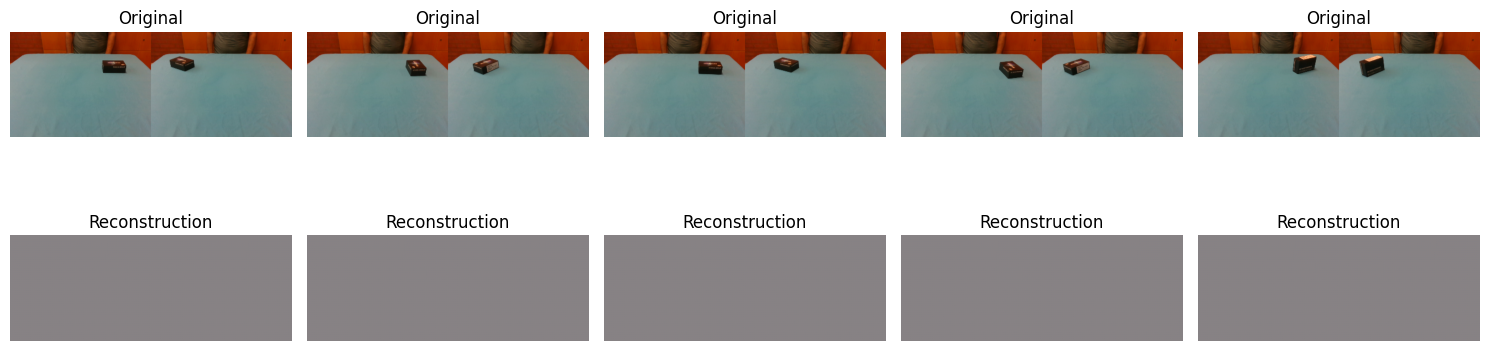

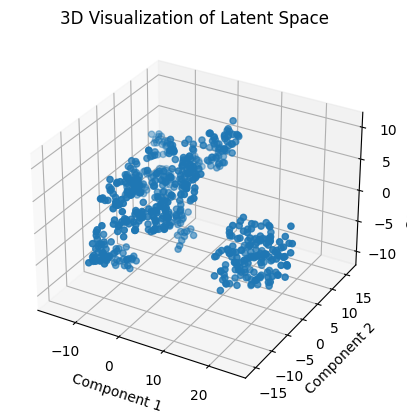

In [5]:
plot_loss_histories(cae_batch_loss_history, cae_validation_loss_history)
visualize_reconstruction(trained_cae, test_loader, num_samples=5)
visualize_latent_space(trained_cae, test_loader, n_components=3)

In [ ]:
"early_stopping" after some epochs no improvements.
"superimpose"